# Portfolio Optimization: Modern Portfolio Theory Implementation

## From Statistical Analysis to Investment Decisions

This notebook implements **Modern Portfolio Theory (MPT)** using our statistical findings to construct optimal portfolios.

### What We'll Build:
1. **Efficient Frontier**: Risk-return trade-off visualization
2. **Optimal Portfolios**: Maximum Sharpe, Minimum Variance
3. **Risk-Parity Portfolio**: Equal risk contribution
4. **Performance Backtesting**: Historical validation
5. **Portfolio Analytics**: Comprehensive risk metrics

In [20]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Portfolio optimization libraries loaded")

✓ Portfolio optimization libraries loaded


## Load Previous Analysis Results

In [21]:
# Load data from previous analysis
tickers = ["IVV", "IEF", "GLD"]

# Load returns
path = '../data/sample_data.csv'
data = pd.read_csv(path, index_col=0, parse_dates=True, header=[0, 1])
price = pd.DataFrame({t: data[t]['Close'] for t in tickers})
log_returns = np.log(price / price.shift(1)).dropna()

# Load statistical results
stat_results = pd.read_csv('../data/statistical_results.csv', index_col=0)
risk_summary = pd.read_csv('../data/risk_summary.csv', index_col=0)

print(f"Data loaded: {log_returns.shape[0]} trading days")
print(f"Date range: {log_returns.index[0].date()} to {log_returns.index[-1].date()}")
print("\nStatistical Summary:")
print(risk_summary.round(3))

Data loaded: 5218 trading days
Date range: 2005-01-04 to 2025-09-30

Statistical Summary:
     Annual Return (%)  Annual Vol (%)  Sharpe Ratio  Max Drawdown (%)  \
ETF                                                                      
IVV             10.143          19.021         0.428           -59.338   
IEF              3.240           6.816         0.182           -24.712   
GLD             10.199          17.582         0.466           -49.221   

     Skewness  Kurtosis Stationary Normal  VaR 95% (%)  CVaR 95% (%)  \
ETF                                                                    
IVV    -0.465    12.499          ✓      ✗       -1.812        -2.991   
IEF     0.110     2.663          ✓      ✗       -0.681        -0.941   
GLD    -0.299     5.840          ✓      ✗       -1.747        -2.633   

     Sortino Ratio  Calmar Ratio  
ETF                               
IVV          0.509         0.171  
IEF          0.278         0.131  
GLD          0.623         0.207  


## 1. Modern Portfolio Theory Foundations

### Key Equations:
1. **Portfolio Return**: \(R_p = \sum w_i R_i\)
2. **Portfolio Variance**: \(\sigma_p^2 = \sum \sum w_i w_j \sigma_{ij}\)
3. **Sharpe Ratio**: \(S = \frac{R_p - R_f}{\sigma_p}\)

Where:
- \(w_i\) = weight of asset i
- \(R_i\) = return of asset i
- \(\sigma_{ij}\) = covariance between assets i and j

In [22]:
# In the "portfolio-calculations" cell, REPLACE with this:

def calculate_portfolio_stats(weights, returns, cov_matrix, risk_free_rate=0.02):
    """Calculate portfolio statistics given weights"""
    # Annualization factor
    days_per_year = 252
    
    # Portfolio return (annualized)
    port_return = np.sum(returns.mean() * weights) * days_per_year
    
    # FIX: cov_matrix should already be annualized, so don't multiply by days_per_year again
    # OLD: port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * days_per_year, weights)))
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Sharpe ratio
    sharpe = (port_return - risk_free_rate) / port_vol if port_vol > 0 else 0
    
    return {
        'return': port_return,
        'volatility': port_vol,
        'sharpe': sharpe
    }

# Get inputs - make sure cov_matrix is properly annualized
expected_returns = log_returns.mean() * 252  # Annualized
cov_matrix = log_returns.cov() * 252  # Annualized covariance

print("Annualized Expected Returns:")
print(expected_returns.round(4))
print("\nAnnualized Covariance Matrix:")
print(cov_matrix.round(6))

# Verify that the covariance matrix looks reasonable
print("\nIndividual Asset Volatilities (Annualized):")
for i, ticker in enumerate(tickers):
    vol = np.sqrt(cov_matrix.iloc[i, i])
    print(f"  {ticker}: {vol:.2%}")

Annualized Expected Returns:
IVV    0.1014
IEF    0.0324
GLD    0.1020
dtype: float64

Annualized Covariance Matrix:
          IVV       IEF       GLD
IVV  0.036179 -0.003900  0.001811
IEF -0.003900  0.004645  0.002520
GLD  0.001811  0.002520  0.030914

Individual Asset Volatilities (Annualized):
  IVV: 19.02%
  IEF: 6.82%
  GLD: 17.58%


## 2. Efficient Frontier Calculation

The **Efficient Frontier** shows the set of optimal portfolios that offer:
- Highest expected return for a given level of risk
- Lowest risk for a given level of expected return

In [23]:
def generate_random_portfolios(num_portfolios, returns, cov_matrix, risk_free_rate=0.02):
    """Generate random portfolios for efficient frontier"""
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        # Generate random weights (sum to 1)
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        # Calculate portfolio statistics
        port_stats = calculate_portfolio_stats(weights, returns, cov_matrix, risk_free_rate)
        
        results[0, i] = port_stats['volatility']
        results[1, i] = port_stats['return']
        results[2, i] = port_stats['sharpe']
    
    return results, weights_record

# Generate 10,000 random portfolios
num_portfolios = 10000
results, weights = generate_random_portfolios(num_portfolios, log_returns, cov_matrix)

# Convert to DataFrame for analysis
portfolios = pd.DataFrame({
    'Volatility': results[0],
    'Return': results[1],
    'Sharpe': results[2]
})

print(f"Generated {num_portfolios:,} random portfolios")
print("\nPortfolio Statistics Summary:")
print(portfolios.describe().round(4))

Generated 10,000 random portfolios

Portfolio Statistics Summary:
       Volatility      Return      Sharpe
count  10000.0000  10000.0000  10000.0000
mean       0.0991      0.0785      0.5926
std        0.0220      0.0125      0.0573
min        0.0559      0.0341      0.2129
25%        0.0840      0.0706      0.5610
50%        0.0963      0.0786      0.6117
75%        0.1138      0.0877      0.6363
max        0.1876      0.1020      0.6570


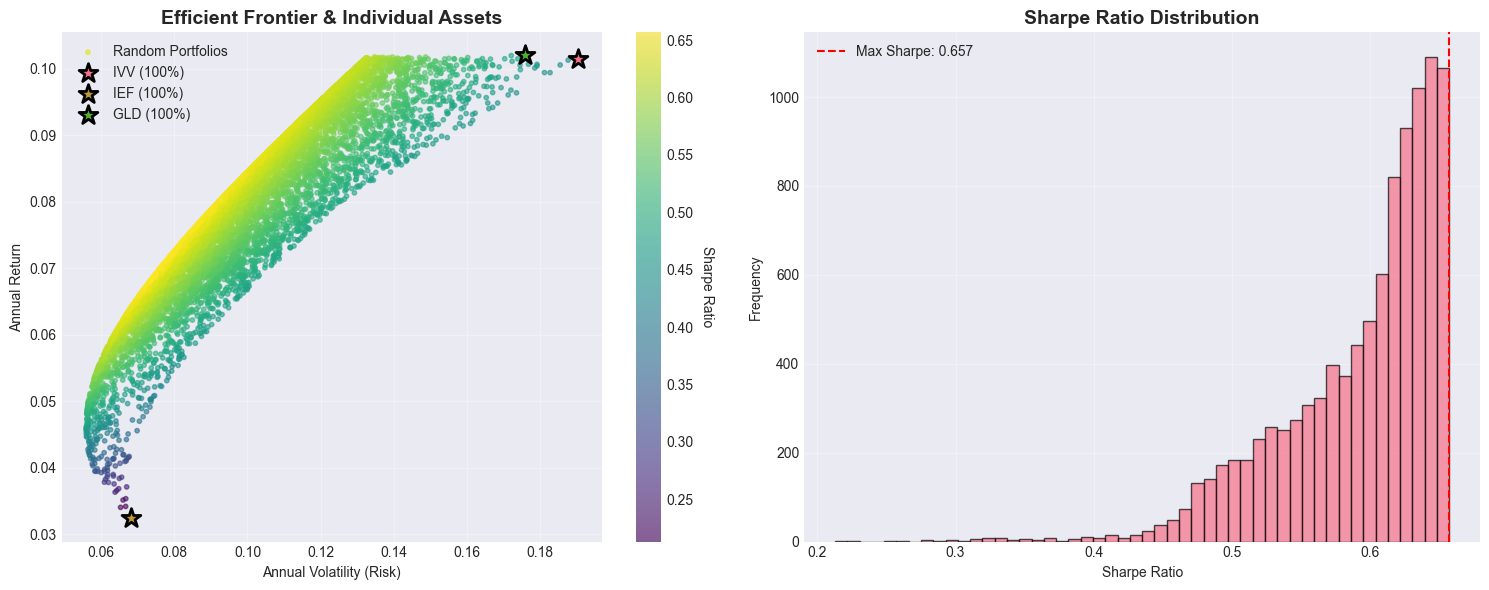

In [24]:
# Plot Efficient Frontier
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Efficient Frontier with individual assets
scatter = axes[0].scatter(portfolios['Volatility'], portfolios['Return'], 
                         c=portfolios['Sharpe'], cmap='viridis', 
                         alpha=0.6, s=10, label='Random Portfolios')

# Plot individual assets
for idx, ticker in enumerate(tickers):
    axes[0].scatter(np.sqrt(cov_matrix.iloc[idx, idx]), expected_returns.iloc[idx], 
                   s=200, marker='*', edgecolors='black', linewidth=2, 
                   label=f'{ticker} (100%)', zorder=5)

axes[0].set_xlabel('Annual Volatility (Risk)')
axes[0].set_ylabel('Annual Return')
axes[0].set_title('Efficient Frontier & Individual Assets', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Add colorbar for Sharpe ratio
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=15)

# Plot 2: Sharpe ratio distribution
axes[1].hist(portfolios['Sharpe'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=portfolios['Sharpe'].max(), color='red', linestyle='--', 
                label=f"Max Sharpe: {portfolios['Sharpe'].max():.3f}")
axes[1].set_xlabel('Sharpe Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Sharpe Ratio Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Finding Optimal Portfolios

We'll find three key portfolios:
1. **Maximum Sharpe Ratio** (Tangency Portfolio)
2. **Minimum Variance** (Safest Portfolio)
3. **Equal-Weighted** (Naive Diversification)

In [25]:
# Optimization functions
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    port_return = portfolio_return(weights, expected_returns)
    port_vol = portfolio_volatility(weights, cov_matrix)
    return -(port_return - risk_free_rate) / port_vol if port_vol > 0 else 1e6

# Constraints: weights sum to 1, no short selling
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Initial guess (equal weights)
init_guess = [1/len(tickers)] * len(tickers)

In [26]:
# 1. Maximum Sharpe Ratio Portfolio
max_sharpe_result = minimize(
    negative_sharpe_ratio,
    init_guess,
    args=(expected_returns, cov_matrix, 0.02),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# 2. Minimum Variance Portfolio
min_vol_result = minimize(
    portfolio_volatility,
    init_guess,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# 3. Equal-Weighted Portfolio
equal_weights = np.array([1/len(tickers)] * len(tickers))

# Calculate statistics for each portfolio
portfolios_dict = {
    'Max Sharpe': max_sharpe_result.x,
    'Min Volatility': min_vol_result.x,
    'Equal Weight': equal_weights
}

# Create summary table
portfolio_summary = []

for name, weights in portfolios_dict.items():
    stats = calculate_portfolio_stats(weights, log_returns, cov_matrix)
    
    # Calculate additional metrics
    # Maximum Drawdown (simplified)
    port_returns = (log_returns * weights).sum(axis=1)
    cumulative = (1 + port_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()
    
    portfolio_summary.append({
        'Portfolio': name,
        'IVV %': f"{weights[0]*100:.1f}%",
        'IEF %': f"{weights[1]*100:.1f}%",
        'GLD %': f"{weights[2]*100:.1f}%",
        'Return %': f"{stats['return']*100:.2f}%",
        'Volatility %': f"{stats['volatility']*100:.2f}%",
        'Sharpe Ratio': f"{stats['sharpe']:.3f}",
        'Max Drawdown %': f"{max_dd*100:.2f}%"
    })

portfolio_df = pd.DataFrame(portfolio_summary)
print("OPTIMAL PORTFOLIOS COMPARISON")
print("="*80)
print(portfolio_df.to_string(index=False))

OPTIMAL PORTFOLIOS COMPARISON
     Portfolio IVV % IEF % GLD % Return % Volatility % Sharpe Ratio Max Drawdown %
    Max Sharpe 30.3% 43.1% 26.5%    7.18%        7.89%        0.657        -20.01%
Min Volatility 17.1% 80.4%  2.5%    4.60%        5.59%        0.464        -19.46%
  Equal Weight 33.3% 33.3% 33.3%    7.86%        8.98%        0.653        -23.33%


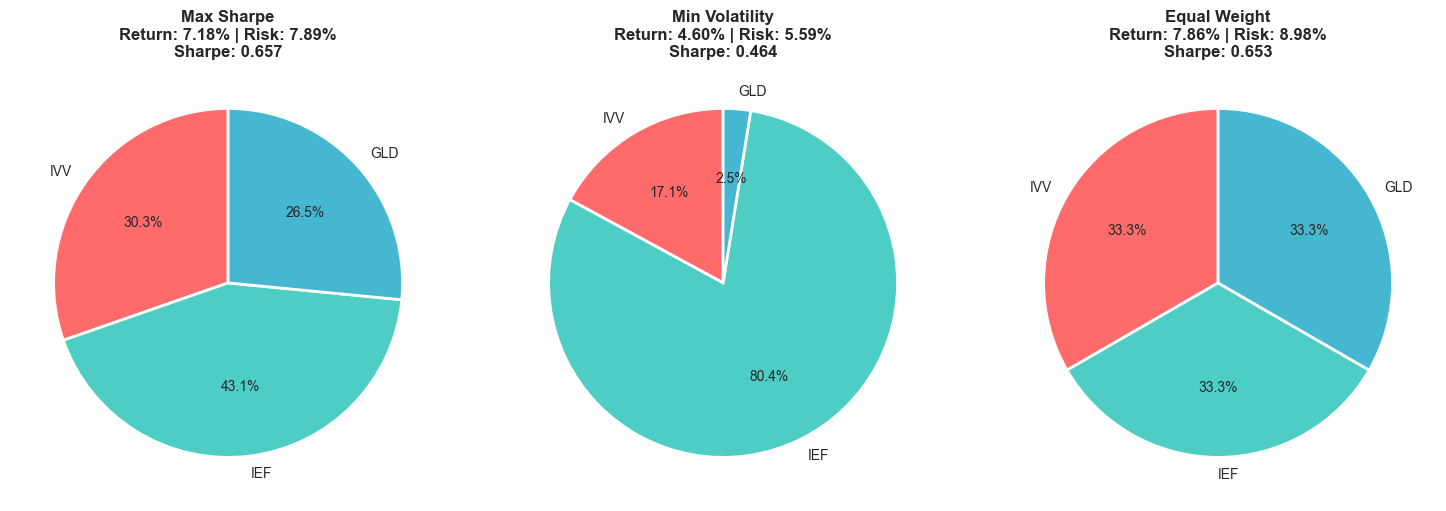

In [27]:
# Visualize portfolio weights
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (name, weights) in enumerate(portfolios_dict.items()):
    axes[idx].pie(weights, labels=tickers, colors=colors, autopct='%1.1f%%', 
                 startangle=90, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
    stats = calculate_portfolio_stats(weights, log_returns, cov_matrix)
    axes[idx].set_title(f'{name}\nReturn: {stats["return"]*100:.2f}% | ' +
                       f'Risk: {stats["volatility"]*100:.2f}%\n' +
                       f'Sharpe: {stats["sharpe"]:.3f}', 
                       fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Risk Parity Portfolio

**Risk Parity** allocates based on risk contribution rather than capital allocation. Each asset contributes equally to portfolio risk.

In [28]:
def calculate_risk_contribution(weights, cov_matrix):
    """Calculate risk contribution of each asset"""
    port_vol = portfolio_volatility(weights, cov_matrix)
    marginal_risk = np.dot(cov_matrix, weights) / port_vol
    risk_contribution = weights * marginal_risk
    return risk_contribution / port_vol  # Percentage contribution

def risk_parity_objective(weights, cov_matrix):
    """Objective: equal risk contribution"""
    n = len(weights)
    target_risk = np.ones(n) / n  # Equal risk contribution
    actual_risk = calculate_risk_contribution(weights, cov_matrix)
    return np.sum((actual_risk - target_risk) ** 2)

# Optimize for risk parity
risk_parity_result = minimize(
    risk_parity_objective,
    init_guess,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

risk_parity_weights = risk_parity_result.x
risk_contributions = calculate_risk_contribution(risk_parity_weights, cov_matrix)

# Display results
print("RISK PARITY PORTFOLIO ANALYSIS")
print("="*60)
print("\nPortfolio Weights:")
for ticker, weight in zip(tickers, risk_parity_weights):
    print(f"  {ticker}: {weight*100:.1f}%")

print("\nRisk Contributions (Target: 33.3% each):")
for ticker, contribution in zip(tickers, risk_contributions):
    print(f"  {ticker}: {contribution*100:.1f}%")

# Calculate portfolio statistics
rp_stats = calculate_portfolio_stats(risk_parity_weights, log_returns, cov_matrix)
print(f"\nRisk Parity Portfolio Performance:")
print(f"  Return: {rp_stats['return']*100:.2f}%")
print(f"  Volatility: {rp_stats['volatility']*100:.2f}%")
print(f"  Sharpe Ratio: {rp_stats['sharpe']:.3f}")

RISK PARITY PORTFOLIO ANALYSIS

Portfolio Weights:
  IVV: 22.5%
  IEF: 59.2%
  GLD: 18.3%

Risk Contributions (Target: 33.3% each):
  IVV: 33.3%
  IEF: 33.3%
  GLD: 33.3%

Risk Parity Portfolio Performance:
  Return: 6.07%
  Volatility: 6.44%
  Sharpe Ratio: 0.631


## 5. Portfolio Performance Backtesting

In [29]:
# Backtest portfolio performance
def backtest_portfolio(weights, returns, initial_capital=10000):
    """Backtest portfolio with given weights"""
    # Calculate portfolio returns
    portfolio_returns = (returns * weights).sum(axis=1)
    
    # Calculate equity curve
    equity = initial_capital * (1 + portfolio_returns).cumprod()
    
    # Calculate metrics
    total_return = (equity.iloc[-1] / initial_capital) - 1
    
    # Annualized metrics
    years = len(returns) / 252
    cagr = (1 + total_return) ** (1/years) - 1
    
    # Maximum drawdown
    running_max = equity.expanding().max()
    drawdown = (equity - running_max) / running_max
    max_dd = drawdown.min()
    
    # Volatility (annualized)
    vol = portfolio_returns.std() * np.sqrt(252)
    
    return {
        'equity': equity,
        'returns': portfolio_returns,
        'total_return': total_return,
        'cagr': cagr,
        'volatility': vol,
        'max_drawdown': max_dd,
        'sharpe': (cagr - 0.02) / vol if vol > 0 else 0
    }

# Backtest all portfolios
backtest_results = {}
portfolios_to_test = {
    'Max Sharpe': max_sharpe_result.x,
    'Min Volatility': min_vol_result.x,
    'Equal Weight': equal_weights,
    'Risk Parity': risk_parity_weights
}

for name, weights in portfolios_to_test.items():
    backtest_results[name] = backtest_portfolio(weights, log_returns)

# Compare performance
comparison_data = []

for name, results in backtest_results.items():
    comparison_data.append({
        'Portfolio': name,
        'CAGR %': f"{results['cagr']*100:.2f}%",
        'Total Return %': f"{results['total_return']*100:.2f}%",
        'Volatility %': f"{results['volatility']*100:.2f}%",
        'Max DD %': f"{results['max_drawdown']*100:.2f}%",
        'Sharpe Ratio': f"{results['sharpe']:.3f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nBACKTESTING RESULTS (Full History)")
print("="*80)
print(comparison_df.to_string(index=False))


BACKTESTING RESULTS (Full History)
     Portfolio CAGR % Total Return % Volatility % Max DD % Sharpe Ratio
    Max Sharpe  7.11%        314.66%        7.89%  -20.01%        0.648
Min Volatility  4.54%        150.70%        5.59%  -19.46%        0.454
  Equal Weight  7.74%        368.26%        8.98%  -23.33%        0.639
   Risk Parity  6.03%        236.28%        6.44%  -18.35%        0.626


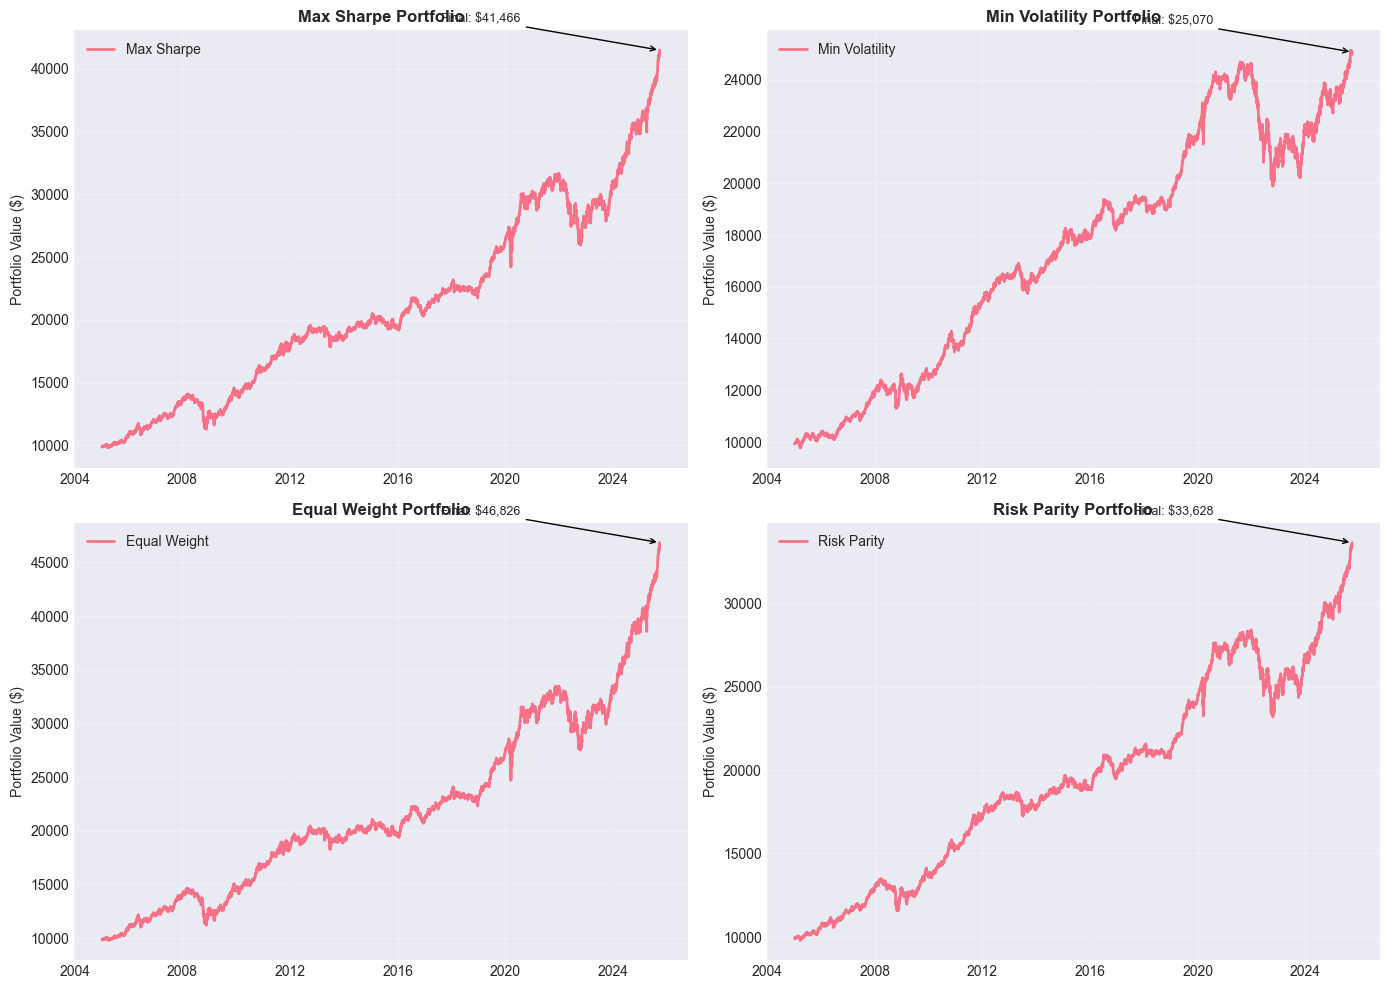

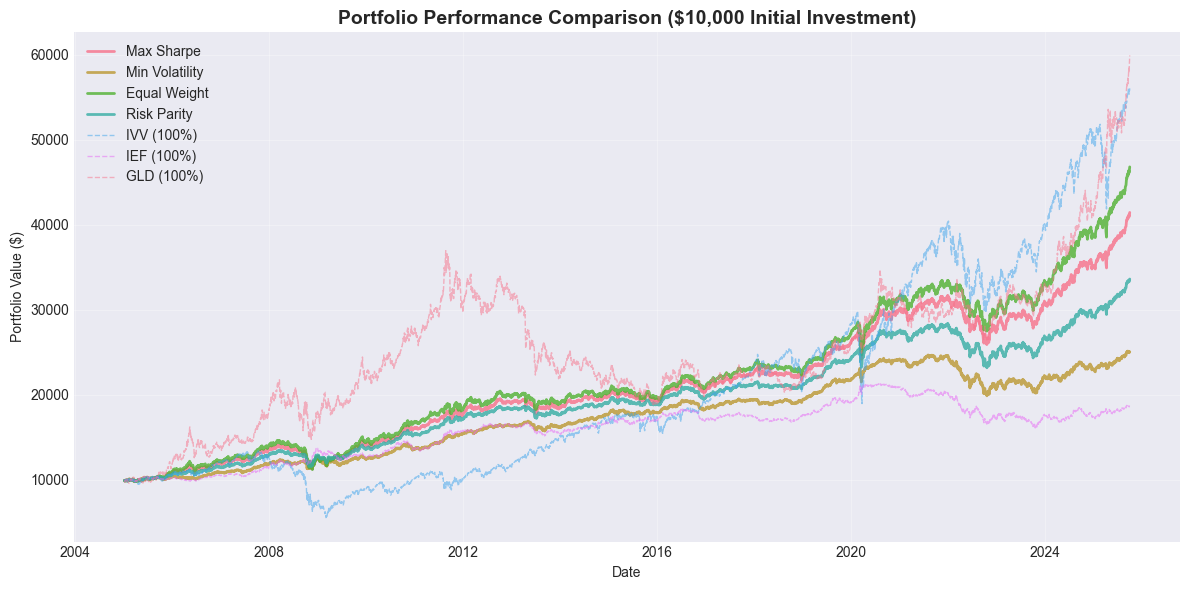

In [30]:
# Plot equity curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, results) in enumerate(backtest_results.items()):
    if idx < 4:  # We have 4 portfolios
        axes[idx].plot(results['equity'].index, results['equity'], 
                      linewidth=2, label=name)
        axes[idx].set_title(f'{name} Portfolio', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Portfolio Value ($)')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(loc='upper left')
        
        # Add final value annotation
        final_val = results['equity'].iloc[-1]
        axes[idx].annotate(f'Final: ${final_val:,.0f}', 
                          xy=(results['equity'].index[-1], final_val),
                          xytext=(-100, 20), textcoords='offset points',
                          arrowprops=dict(arrowstyle='->'),
                          fontsize=9, ha='right')

plt.tight_layout()
plt.show()

# Combined equity curve
plt.figure(figsize=(12, 6))
for name, results in backtest_results.items():
    plt.plot(results['equity'].index, results['equity'], 
             linewidth=2, label=name, alpha=0.8)

# Add individual assets for comparison
for ticker in tickers:
    asset_equity = 10000 * (1 + log_returns[ticker]).cumprod()
    plt.plot(asset_equity.index, asset_equity, '--', 
             linewidth=1, label=f'{ticker} (100%)', alpha=0.5)

plt.title('Portfolio Performance Comparison ($10,000 Initial Investment)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Rolling Portfolio Analysis

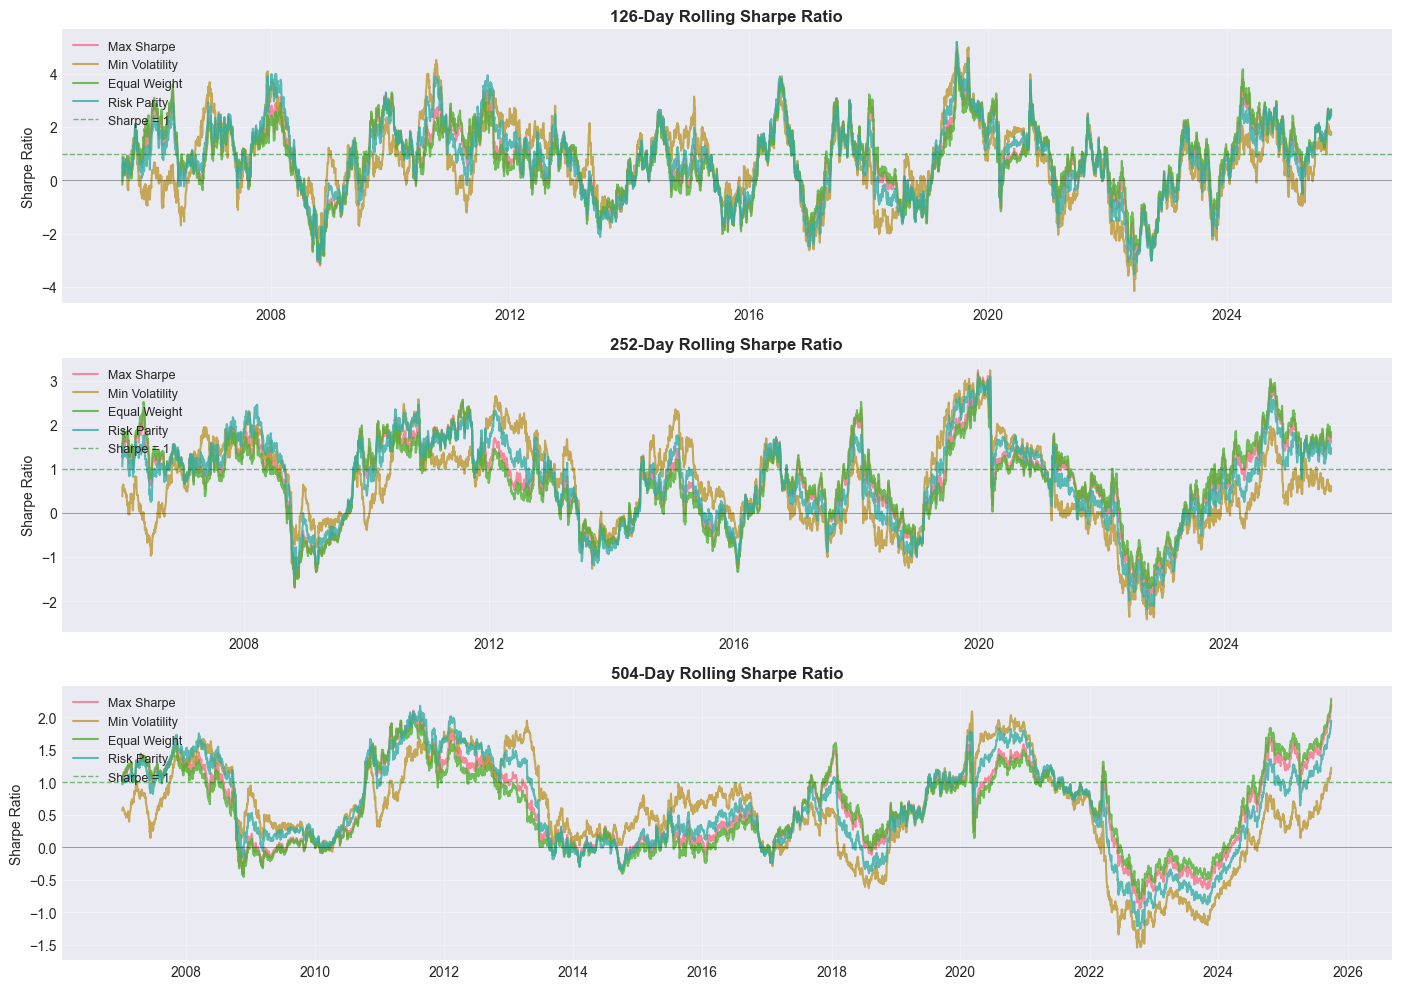

In [31]:
# Analyze rolling performance
def calculate_rolling_sharpe(returns, window=252, risk_free_rate=0.02):
    """Calculate rolling Sharpe ratio"""
    excess_returns = returns - risk_free_rate/252
    rolling_mean = excess_returns.rolling(window).mean() * 252
    rolling_std = returns.rolling(window).std() * np.sqrt(252)
    rolling_sharpe = rolling_mean / rolling_std
    return rolling_sharpe

# Calculate rolling Sharpe for each portfolio
rolling_windows = [126, 252, 504]  # 6 months, 1 year, 2 years

fig, axes = plt.subplots(len(rolling_windows), 1, figsize=(14, 10))

for idx, window in enumerate(rolling_windows):
    ax = axes[idx]
    
    for name, results in backtest_results.items():
        rolling_sharpe = calculate_rolling_sharpe(results['returns'], window)
        ax.plot(rolling_sharpe.index, rolling_sharpe, 
                linewidth=1.5, label=name, alpha=0.8)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.axhline(y=1, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Sharpe = 1')
    
    ax.set_title(f'{window}-Day Rolling Sharpe Ratio', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sharpe Ratio')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Sensitivity Analysis & Robustness Checks

In [32]:
# Test different time periods
periods = {
    'Full History': (log_returns.index[0], log_returns.index[-1]),
    'Pre-2008 Crisis': (log_returns.index[0], pd.Timestamp('2007-12-31')),
    'Post-2008 Recovery': (pd.Timestamp('2009-01-01'), pd.Timestamp('2019-12-31')),
    'Recent Years': (pd.Timestamp('2020-01-01'), log_returns.index[-1])
}

period_results = []

for period_name, (start_date, end_date) in periods.items():
    # Filter data for period
    mask = (log_returns.index >= start_date) & (log_returns.index <= end_date)
    period_returns = log_returns[mask]
    
    if len(period_returns) > 252:  # Require at least 1 year of data
        # Recalculate inputs for this period
        period_exp_returns = period_returns.mean() * 252
        period_cov = period_returns.cov() * 252
        
        # Calculate max Sharpe portfolio for this period
        result = minimize(
            negative_sharpe_ratio,
            init_guess,
            args=(period_exp_returns, period_cov, 0.02),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        
        # Calculate statistics
        stats = calculate_portfolio_stats(result.x, period_returns, period_cov)
        
        period_results.append({
            'Period': period_name,
            'Start': start_date.date(),
            'End': end_date.date(),
            'Days': len(period_returns),
            'IVV %': f"{result.x[0]*100:.1f}%",
            'IEF %': f"{result.x[1]*100:.1f}%",
            'GLD %': f"{result.x[2]*100:.1f}%",
            'Return %': f"{stats['return']*100:.2f}%",
            'Sharpe': f"{stats['sharpe']:.3f}"
        })

sensitivity_df = pd.DataFrame(period_results)
print("SENSITIVITY ANALYSIS: Portfolio Performance Across Different Periods")
print("="*90)
print(sensitivity_df.to_string(index=False))

SENSITIVITY ANALYSIS: Portfolio Performance Across Different Periods
            Period      Start        End  Days IVV % IEF % GLD % Return % Sharpe
      Full History 2005-01-04 2025-09-30  5218 30.3% 43.1% 26.5%    7.18%  0.657
   Pre-2008 Crisis 2005-01-04 2007-12-31   753 17.5% 60.3% 22.2%    9.29%  1.303
Post-2008 Recovery 2009-01-01 2019-12-31  2768 38.0% 61.5%  0.6%    7.23%  0.915
      Recent Years 2020-01-01 2025-09-30  1444 30.0%  0.0% 70.0%   15.40%  0.990


## 8. Conclusions & Investment Recommendations

In [33]:
print("="*80)
print("PORTFOLIO OPTIMIZATION: FINAL RECOMMENDATIONS")
print("="*80)

# Asegurar que las columnas son numéricas
# Convertir porcentajes a valores float
comparison_df['Sharpe Ratio'] = pd.to_numeric(comparison_df['Sharpe Ratio'], errors='coerce')
comparison_df['Max DD %'] = pd.to_numeric(comparison_df['Max DD %'].str.replace('%', ''), errors='coerce') / 100

# Identificar best portfolios (eliminando NaN si existen)
best_sharpe = comparison_df.loc[comparison_df['Sharpe Ratio'].idxmax()]
# Para drawdown: queremos el MENOS negativo (mayor valor, ya que son negativos)
best_drawdown = comparison_df.loc[comparison_df['Max DD %'].idxmax()]  # idxmax busca el valor menos negativo

print("\n TOP PERFORMERS BY METRIC:")
print(f"1. Best Risk-Adjusted Return (Sharpe): {best_sharpe['Portfolio']} (Sharpe: {best_sharpe['Sharpe Ratio']:.3f})")
print(f"2. Best Drawdown Protection: {best_drawdown['Portfolio']} (Max DD: {best_drawdown['Max DD %']*100:.1f}%)")

# El resto del código sigue igual...

PORTFOLIO OPTIMIZATION: FINAL RECOMMENDATIONS

 TOP PERFORMERS BY METRIC:
1. Best Risk-Adjusted Return (Sharpe): Max Sharpe (Sharpe: 0.648)
2. Best Drawdown Protection: Risk Parity (Max DD: -18.4%)


## Save Results for Future Analysis

In [34]:
# Save all portfolio results
portfolio_results = {
    'optimal_weights': pd.DataFrame({
        'Portfolio': list(portfolios_dict.keys()) + ['Risk Parity'],
        'IVV': list([w[0] for w in portfolios_dict.values()]) + [risk_parity_weights[0]],
        'IEF': list([w[1] for w in portfolios_dict.values()]) + [risk_parity_weights[1]],
        'GLD': list([w[2] for w in portfolios_dict.values()]) + [risk_parity_weights[2]]
    }),
    'performance_summary': portfolio_df,
    'backtest_results': comparison_df,
    'sensitivity_analysis': sensitivity_df
}

# Save to CSV
portfolio_results['optimal_weights'].to_csv('../data/portfolio_weights.csv', index=False)
portfolio_results['performance_summary'].to_csv('../data/portfolio_performance.csv', index=False)
portfolio_results['backtest_results'].to_csv('../data/backtest_results.csv', index=False)

print("✓ Portfolio results saved to '../data/' folder")
print("\n PORTFOLIO OPTIMIZATION COMPLETE!")
print("\nKey insights have been generated and saved.")
print("Next: Implement SQL integration and create Power BI dashboard.")

✓ Portfolio results saved to '../data/' folder

 PORTFOLIO OPTIMIZATION COMPLETE!

Key insights have been generated and saved.
Next: Implement SQL integration and create Power BI dashboard.
